In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# カレントディレクトリの変更
import os
os.chdir('/content/drive/My Drive/Kaggle/Riiid')

# カレントディレクトリの取得
print(os.getcwd())

/content/drive/My Drive/Kaggle/Riiid


In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



<h1><center>Riiid! Answer Correctness Prediction.</center></h1>

<center><img src="https://www.riiid.co/assets/opengraph.png"></center>


# Contents <a id='0.1'></a>

* [EDA](#1)
    * [コンペ概要](#1.1)
    * [pip install](#1.2)
    * [Timeline](#1.3)
    * [Prizes](#1.4)
    * [Code Requirements](#1.5)
* [train.csv](#2)
* [questions.csv](#3)
* [lectures.csv](#4)
* [example_test_rows.csv](#5)

- インストール

train.csvは

In [4]:
!pip install datatable

In [5]:
# import packages
import numpy as np
import pandas as pd
import datatable as dt

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/train.csv
./input/competition.cpython-37m-x86_64-linux-gnu.so
./input/__init__.py
./input/example_test.csv
./input/lectures.csv
./input/questions.csv
./input/example_sample_submission.csv


In [6]:
%%time

# ディレクトリー
ROOT = './input/' #riiid-test-answer-prediction/'

# ファイル
train = dt.fread(f'{ROOT}train.csv').to_pandas()
questions = pd.read_csv(f'{ROOT}questions.csv')
lectures = pd.read_csv(f'{ROOT}lectures.csv')
example_test = pd.read_csv(f'{ROOT}example_test.csv')
example_sample_submission = pd.read_csv(f'{ROOT}example_sample_submission.csv')

CPU times: user 38 s, sys: 19.1 s, total: 57.1 s
Wall time: 2min 2s


In [7]:
# True, Falseの形式のため、bool型に変換
train.prior_question_had_explanation = train.prior_question_had_explanation.astype(np.bool)

In [8]:
train.shape, questions.shape, lectures.shape, example_test.shape, example_sample_submission.shape

((101230332, 10), (13523, 5), (418, 4), (104, 11), (104, 3))

In [9]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,True
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int32  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int32  
 4   content_type_id                 bool   
 5   task_container_id               int32  
 6   user_answer                     int32  
 7   answered_correctly              int32  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  bool   
dtypes: bool(2), float64(1), int32(6), int64(1)
memory usage: 4.0 GB


In [11]:
train.describe().apply(lambda s: s.apply(lambda x: format(x, '.2f')))

,row_id,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,101230332.00,101230332.00,101230332.00,101230332.00,101230332.00,101230332.00,101230332.00,98878794.00
mean,50615165.50,7703643654.33,1076732424.20,5219.60,904.06,1.38,0.63,25423.81
std,29222679.86,11592655308.53,619716349.50,3866.36,1358.30,1.19,0.52,19948.15
min,0.00,0.00,115.00,0.00,0.00,-1.00,-1.00,0.00
25%,25307582.75,524343559.00,540811564.00,2063.00,104.00,0.00,0.00,16000.00
50%,50615165.50,2674233764.50,1071781070.00,5026.00,382.00,1.00,1.00,21000.00
75%,75922748.25,9924550562.75,1615741676.00,7425.00,1094.00,3.00,1.00,29666.00
max,101230331.00,87425772049.00,2147482888.00,32736.00,9999.00,3.00,1.00,300000.00


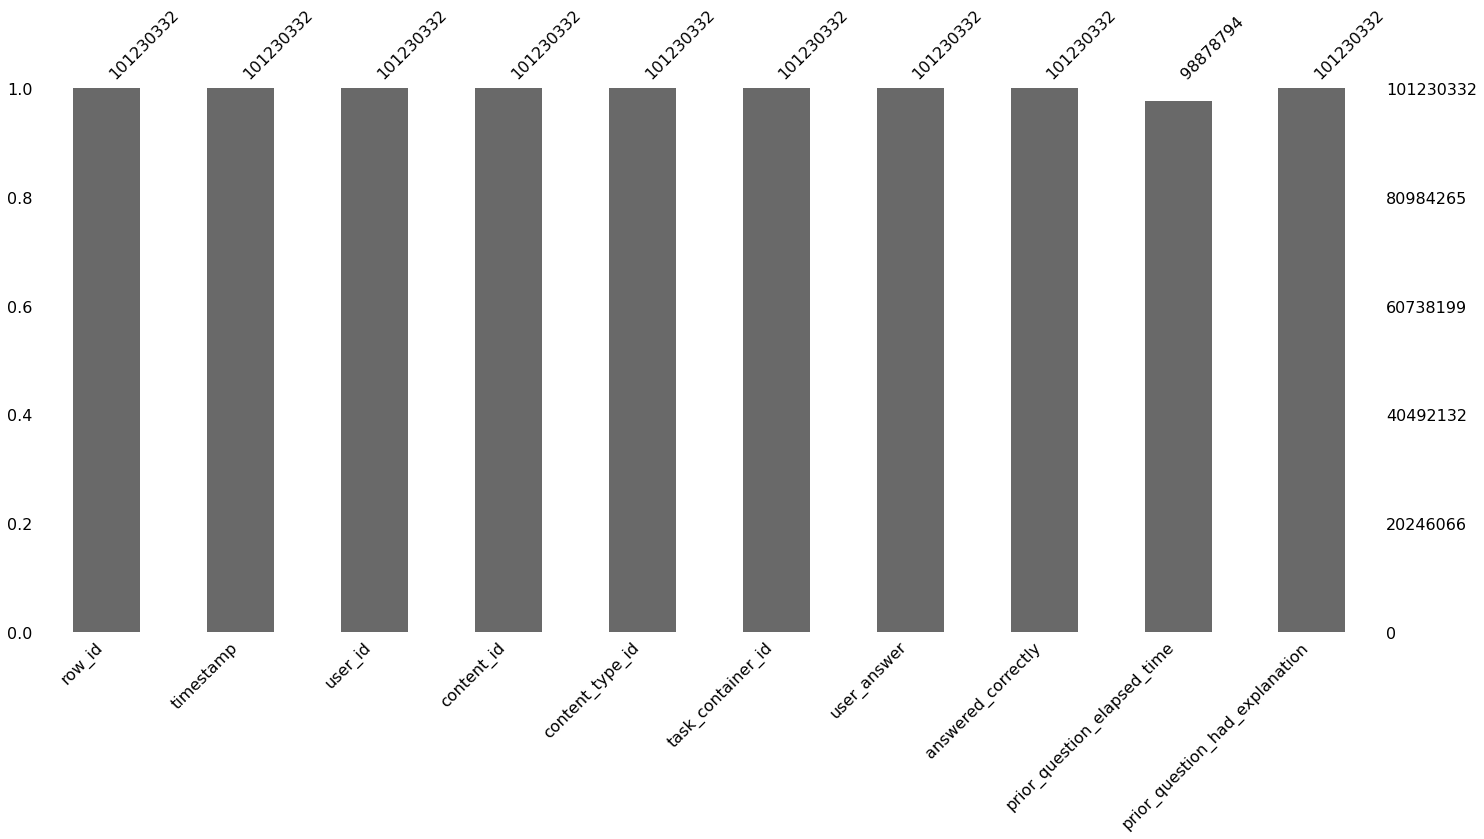

In [12]:
import missingno as msno
msno.bar(train)
#prior_question_elapsed_time以外に欠損値無し。

主催者より lecturesを含む行の投稿は認められていないため、
分析の切り口としてtrainデータをquestionとlectureに分割

questionを中心に分析を進める

- You should not try to submit anything for the rows that contain lectures.

In [13]:
train_question = train[train.content_type_id == False]
train_lecture = train[train.content_type_id == True]

In [14]:
len(train_question) + len(train_lecture)

101230332

In [15]:
labels = ['question', 'lecture']
values = train.content_type_id.value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

カラムを１列ずつ詳細に把握する

## user_id ##

In [16]:
unique_user = train_question.user_id.nunique()

print("user_idのユニーク件数：{}件　" .format(unique_user))

user_idのユニーク件数：393656件　


In [17]:
print("trainデータ(question)に締めるuser_id一件あたりの件数:{}件" .format(len(train_question) // unique_user))

trainデータ(question)に締めるuser_id一件あたりの件数:252件


In [18]:
print("trainデータ(lecture)に締めるuser_id一件あたりの件数:{}件" .format(len(train_lecture) // unique_user))

trainデータ(lecture)に締めるuser_id一件あたりの件数:4件


- user_idでグループ化を行い、平均値、カウントを取りデータの分布を確認

In [19]:
group_by_user_id = train_question.groupby('user_id')

In [20]:
answered_correctly_user =  group_by_user_id.agg({'answered_correctly': ['mean', 'count'] })

In [21]:
answered_correctly_user[('answered_correctly','mean')].describe()

count    393656.000000
mean          0.545183
std           0.163378
min           0.000000
25%           0.433333
50%           0.571429
75%           0.666667
max           1.000000
Name: (answered_correctly, mean), dtype: float64

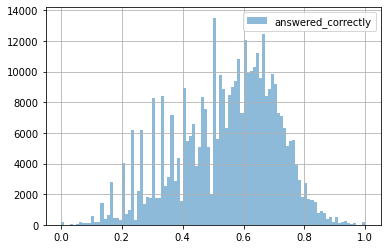

In [22]:
answered_correctly_user[('answered_correctly','mean')].hist(bins=100, alpha=0.5, legend=True)

In [23]:
answered_correctly_user[('answered_correctly','count')].describe()

count    393656.000000
mean        252.177790
std         734.721108
min           1.000000
25%          30.000000
50%          40.000000
75%         154.000000
max       17609.000000
Name: (answered_correctly, count), dtype: float64

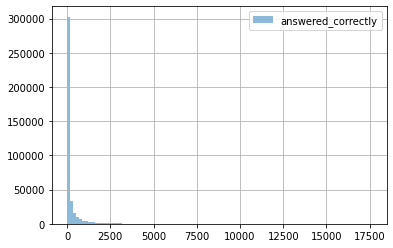

In [24]:
answered_correctly_user[('answered_correctly','count')].hist(bins=100, alpha=0.5, legend=True)

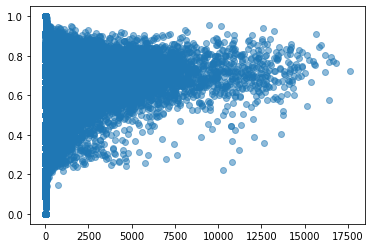

In [25]:
plt.scatter(x=answered_correctly_user[('answered_correctly','count')],
            y=answered_correctly_user[ ('answered_correctly','mean')], alpha=0.5)

In [26]:
user_mean = dict()
for i in range(0, max(answered_correctly_user[('answered_correctly','count')]), 10):
  temp_mean = answered_correctly_user[answered_correctly_user[('answered_correctly','count')] == i][('answered_correctly','mean')].mean()
  user_mean[i] = temp_mean

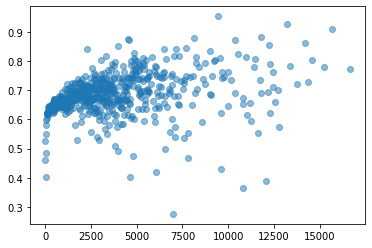

In [27]:
plt.scatter(x=user_mean.keys(), y=user_mean.values(), alpha=0.5)

一般的な感覚として、学習時間が増えれば、習熟度が増して得点が伸びる事が期待される。

カウント(ユーザーのインタラクション回数(questionの取組回数))が多いユーザーの平均値(正解率)が高い傾向にあるものと考えられる。


## content_id ##

In [28]:
unique_content = train_question.content_id.nunique()

print("content_idのユニーク件数：{}件　" .format(unique_content))

content_idのユニーク件数：13523件　


In [29]:
print("trainデータ(question)に締めるcontent_id一件あたりの件数:{}件" .format(len(train_question) // unique_content))

trainデータ(question)に締めるcontent_id一件あたりの件数:7340件


In [30]:
print("trainデータ(lecture)に締めるcontent_id一件あたりの件数:{}件" .format(len(train_lecture) // unique_content))

trainデータ(lecture)に締めるcontent_id一件あたりの件数:144件


- content_idでグループ化を行い、平均値、カウントを取りデータの分布を確認

In [31]:
group_by_content_id = train_question.groupby('content_id')

In [32]:
answered_correctly_content =  group_by_content_id.agg({'answered_correctly': ['mean', 'count'] })

In [33]:
answered_correctly_content[('answered_correctly','mean')].describe()

count    13523.000000
mean         0.709460
std          0.164486
min          0.000000
25%          0.609345
50%          0.734215
75%          0.835116
max          1.000000
Name: (answered_correctly, mean), dtype: float64

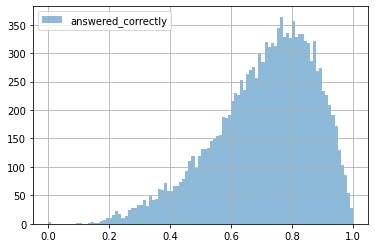

In [34]:
answered_correctly_content[('answered_correctly','mean')].hist(bins=100, alpha=0.5, legend=True)

In [35]:
answered_correctly_content[('answered_correctly','count')].describe()

count     13523.000000
mean       7340.922872
std       11455.927774
min           1.000000
25%        1765.500000
50%        4732.000000
75%        8556.000000
max      213605.000000
Name: (answered_correctly, count), dtype: float64

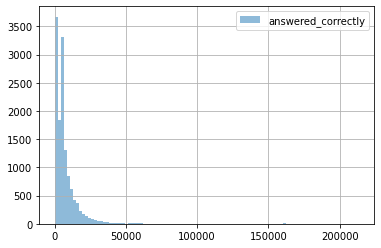

In [36]:
answered_correctly_content[('answered_correctly','count')].hist(bins=100, alpha=0.5, legend=True)

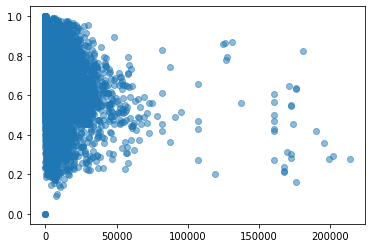

In [37]:
plt.scatter(x=answered_correctly_content[('answered_correctly','count')],
            y=answered_correctly_content[ ('answered_correctly','mean')], alpha=0.5)

## task_container_id ##

`task_container_id`: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

      問題やレクチャーのバッチID。
      例えば、ユーザーは問題文を見る前に3つの問題を一列に並べて見るかもしれません。これら3つの問題はすべてtask_container_idを共有します。

In [38]:
unique_task_container = train_question.task_container_id.nunique()

print("task_container_idのユニーク件数：{}件　" .format(unique_task_container))

task_container_idのユニーク件数：10000件　


In [39]:
print("trainデータ(question)に締めるtask_container_id一件あたりの件数:{}件" .format(len(train_question) // unique_task_container))

trainデータ(question)に締めるtask_container_id一件あたりの件数:9927件


In [40]:
print("trainデータ(lecture)に締めるtask_container_id一件あたりの件数:{}件" .format(len(train_lecture) // unique_task_container))

trainデータ(lecture)に締めるtask_container_id一件あたりの件数:195件


- task_container_idでグループ化を行い、平均値、カウントを取りデータの分布を確認

In [41]:
group_by_task_container_id = train_question.groupby('task_container_id')

In [42]:
answered_correctly_task_container =  group_by_task_container_id.agg({'answered_correctly': ['mean', 'count'] })

In [43]:
answered_correctly_task_container[('answered_correctly','mean')].describe()

count    10000.000000
mean         0.713445
std          0.028725
min          0.314547
25%          0.695377
50%          0.710280
75%          0.729401
max          0.837838
Name: (answered_correctly, mean), dtype: float64

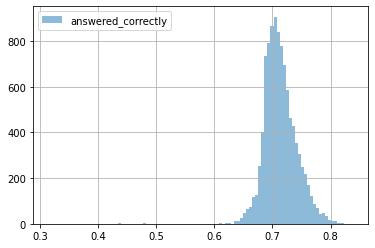

In [44]:
answered_correctly_task_container[('answered_correctly','mean')].hist(bins=100, alpha=0.5, legend=True)

In [45]:
answered_correctly_task_container[('answered_correctly','count')].describe()

count     10000.000000
mean       9927.130000
std       32457.455136
min         169.000000
25%         419.750000
50%        1308.500000
75%        5706.750000
max      801910.000000
Name: (answered_correctly, count), dtype: float64

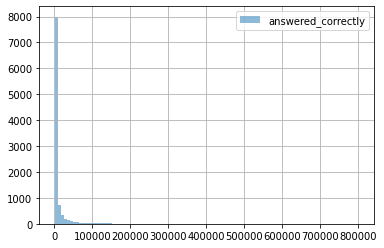

In [46]:
answered_correctly_task_container[('answered_correctly','count')].hist(bins=100, alpha=0.5, legend=True)

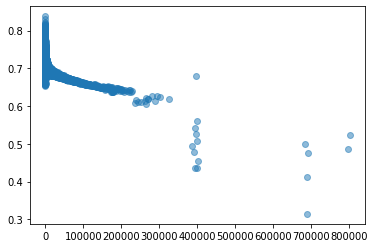

In [47]:
plt.scatter(x=answered_correctly_task_container[('answered_correctly','count')],
            y=answered_correctly_task_container[ ('answered_correctly','mean')], alpha=0.5)

## user_answer ##

- TOEIC試験は、四択問題である。
ここでは、四択である事及び各回答の割合を確認する。

In [48]:
train_question.user_answer.value_counts().sort_index()

0    28186489
1    26990007
2    18010020
3    26084784
Name: user_answer, dtype: int64

In [49]:
labels = ['0', '1', '2', '3']
values = train_question.user_answer.value_counts().sort_index()

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

<余談>
適当に回答する時は2を避ける方が正解率が上がりそうである。:)

## answered_correctly ##

answered_correctlyがターゲットである。

ここでは、0(不正解)及び1(正解)の二値である事、それぞれの割合を確認する。



In [50]:
train_question.answered_correctly.value_counts().sort_index()

0    34026673
1    65244627
Name: answered_correctly, dtype: int64

In [51]:
labels = ['0', '1']
values = train_question.answered_correctly.value_counts().sort_index()

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## prior_question_elapsed_time ##

`prior_question_elapsed_time`: (float32) The average time it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

      ユーザが前の問題バンドルの各問題に回答(レクチャーは無視)するのにかかった平均時間です。
      ユーザーの最初の問題バンドルまたはレクチャーの場合は null です。
      この時間は、ユーザが前の問題バンドルの各問題を解くのにかかった平均時間であることに注意してください。

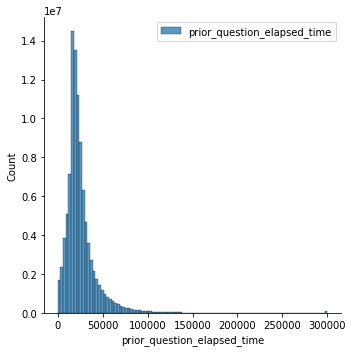

In [52]:
sns.displot(train_question.prior_question_elapsed_time, bins=100,
            label='prior_question_elapsed_time',
            kde=False,rug=False
            )
plt.legend()
plt.show()

In [53]:
train_question.prior_question_elapsed_time.describe().apply(lambda x: format(x, '.2f'))

count    98878794.00
mean        25423.81
std         19948.15
min             0.00
25%         16000.00
50%         21000.00
75%         29666.00
max        300000.00
Name: prior_question_elapsed_time, dtype: object

- prior_question_elapsed_timeの欠損値の埋め方

データを理解する際、まずは平均値、中央値、最頻値などの要約を見るだけでなく、できる限りデータの分布を見る。

データの分布から、prior_question_elapsed_timeの欠損値は平均値、中央値で穴埋めするのではなく、
第一四分位数での穴埋めを行ってみる。

10月26日現在で、第一四分位数での穴埋めは、Notebooksに手法として公開されていない
(スコアが改善される。恐らく0.0004位改善)。

## prior_question_had_explanation ##

`prior_question_had_explanation`: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

      前の問題バンドルに回答した後、その間のレクチャーを無視して、ユーザーが説明と正しい回答を見たかどうかを指定します。
      この値は1つの問題バンドルで共有され、ユーザーの最初の問題バンドルまたはレクチャーではnullとなります。
      通常、ユーザーが最初に見るいくつかの問題は、フィードバックが得られないオンボーディング診断テストの一部でした。

問題に回答後に説明及び正解を見た割合

TOEICの本試験ではないし、問題に回答した後にその説明及び正解を確認する行動は、理解できる。

In [54]:
train_question.prior_question_had_explanation.value_counts()

True     90078066
False     9193234
Name: prior_question_had_explanation, dtype: int64

In [55]:
labels = ['True', 'False']
values = train_question.prior_question_had_explanation.value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [61]:
explanation_mean_user = train_question[['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])

In [64]:
explanation_mean_user.describe()

,prior_question_had_explanation
,mean
count,393656.000000
mean,0.582903
std,0.344665
min,0.000000
25%,0.250000
50%,0.666667
75%,0.905172
max,1.000000


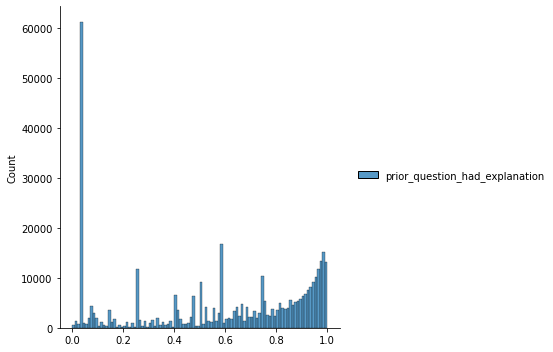

In [67]:
sns.displot(explanation_mean_user, bins=100,
            label='prior_question_had_explanation',
            kde=False,rug=False
            )
#plt.legend()
plt.show()